# P3 submission: Loading and Preprocessing part

In [261]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from collections import Counter

# statistics
from scipy.stats import ttest_rel, ttest_ind
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore') # remove the warnings

# Load ratings.txt

We are processing data extracted from two similar beer rating websites: BeerAdvocate and RateBeer. The primary data structure is outlined in "ratings.txt," which includes user reviews providing information on beer (names, IDs, style, alcohol by volume), breweries, and users (date of review, user details, ratings, and comments on various aspects). Other supporting files include "beers.csv" (aggregated ratings for each beer), "Breweries" (information on breweries and their locations), and "Users" (user details on the number of ratings, reviews, and country of origin).

The most crucial file is "ratings.txt," as others are derived from its content. Due to its significant size (4.3 GB for BeerAdvocate and 3.95 GB for RateBeer), loading directly with a standard pipeline is impractical due to laptop memory limitations. To address this, we split the .txt files into N subfiles and load the data iteratively using a function.

The function allows control over the fraction of initial data loaded via the parameter **Nb_files**, which determines the number of subfiles to load. It also accommodates inherent differences between the two websites, such as additional review columns for BeerAdvocate.

Once loaded into DataFrames, we utilize the sample_data function to randomly sample a fraction of the data, enabling efficient handling of the substantial dataset.

In [262]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './dataset_BeerReviews/BeerAdvocate/ratings_split/'
    else:
        directory = './dataset_BeerReviews/RateBeer/final_rates/'
        
    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [268]:
# Load data : for faster processing, we will only load 1 file out of the whole dataset
#ratings_BA = load_txt_file('BeerAdvocate', 1)
ratings_RB = load_txt_file('RateBeer', 1)

In [271]:
ratings_RB.head(10)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.90,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.60,"Kolor- złoty, klarowny. Piana - drobna, średni..."
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1451646000,fombe89,250510,4,3,1,2,5,1.50,"Botella, de GabÃ³n regalo familiar.31/01/2015C..."
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1445594400,kevnic2008,122778,2,4,2,4,7,1.90,Many thanks for this beer to Erzengel. Pours l...
5,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1444644000,Beerhunter111,227834,2,3,2,3,9,1.90,Many thanks to Erzengel for sharing! Pours cle...
6,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1444212000,Erzengel,83106,4,5,4,5,8,2.60,Many thanks to Travlr for this can! Grainy no...
7,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1430820000,Manslow,175852,2,4,2,3,6,1.70,"Puszka pita w Gabonie. Kolor jasnosłomkowy, pi..."
8,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1401357600,Lowenbrau,37316,3,5,2,3,7,2.00,"330ml bottle. 29-05-2014.From Gabon, courtesy ..."
9,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1374141600,seynie,75452,2,3,3,4,6,1.80,Light yellow with quickly disappearing foam to...


In [266]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
#ratings_BA = sample_data(df = ratings_BA, ratio = 1)
ratings_RB = sample_data(df = ratings_RB, ratio = 1)

In [272]:
print(f"Length of ratings_BA (BeerAdvocate) dataframe : {len(ratings_BA)}")
print(f"Length of ratings_RB (RateBeer) dataframe : {len(ratings_RB)}")
display(ratings_BA.head(2),ratings_RB.head(2))

Length of ratings_BA (BeerAdvocate) dataframe : 444338
Length of ratings_RB (RateBeer) dataframe : 446793


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.90,Cerveza pale lager gabonesa. MÃ¡s floja que la...


### Load the other data

In [274]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

FileNotFoundError: [Errno 2] No such file or directory: './dataset_BeerReviews/BeerAdvocate/beers.csv'

**Check the type**

In [ ]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


**Change the type**

One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [ ]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    #ratings_RB = convert_type(ratings_RB, col)

In [ ]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


## Combine all the dataframes

- matched (already standardized, need to check scales though of numerical features)
- BA (not standardized yet)
- RB (not standardized yet)

First we need to standardize the data from ratings_BA and ratings_RB before combining them with matched (which has already been standardized per year and per website, see paper)

Explain that we duplicate the matched samples (1 from BA and 1 from RB), so that we keep all the reviews, independently of the website.

### Preprocessing : standardize ratings_BA and ratings_RB annually

- Need to add time dimension first: month and year

In [ ]:
def add_time_features(df):
    """
    Adds a 'month' and a 'year' features to the DataFrame based on the 'date' column.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including a 'date' column.

    Returns
    -------
    df_m : DataFrame
        Contains the original data with an additional 'month' and 'year' features.
    """
    # Create a copy of the DataFrame
    df_time = df.copy()
    # Conversion of date feature from timestamp to text date
    pd.to_numeric(df_time['date'], errors='coerce', downcast='integer')
    # Convert 'date' to datetime and extract the date
    df_time.date = df.date.apply(lambda d: pd.to_datetime(d, unit='s'))
    df_time['date'] = df_time['date'].dt.date

    # Extract the month from the 'date' column and add it as a new feature 'month'
    df_time['month'] = pd.to_datetime(df_time['date']).dt.month
    # Extract the year from the 'date' column and add it as a new feature 'year'
    df_time['year'] = pd.to_datetime(df_time['date']).dt.year

    return df_time

def standardize_annually_ratings(df):
    """
    Standardizes the ratings annually and per website.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with standardized ratings with additional column 'standardized_rating'.
                
    """
    df_copy = df.copy()
    grouped = df_copy.groupby('year')['rating'].agg(['mean', 'std'])
    df_copy = pd.merge(df_copy, grouped, left_on='year', right_index=True)
    df_copy['std_rating'] = (df_copy['rating'] - df_copy['mean']) / df_copy['std']
    
    return df_copy, grouped

In [ ]:
# add time feature to standardize ratings by year and by website
ratings_BA_with_time = add_time_features(ratings_BA)
#ratings_RB_with_time = add_time_features(ratings_RB)

# apply standardization
ratings_BA_standardized, mean_std_BA = standardize_annually_ratings(ratings_BA_with_time)
#ratings_RB_standardized, mean_std_RB = standardize_annually_ratings(ratings_RB_with_time)

In [ ]:
def plot_mean_std_errorbar(grouped_BA, grouped_RB):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.errorbar(grouped_BA.index, grouped_BA['mean'], yerr=1.96 * grouped_BA['std'] / np.sqrt(grouped_BA['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'BeerAdvocate')
    plt.errorbar(grouped_RB.index, grouped_RB['mean'], yerr=1.96 * grouped_RB['std'] / np.sqrt(grouped_RB['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'RateBeer')
    plt.title('Mean Ratings across Years')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.errorbar(grouped_BA.index, grouped_BA['std'], yerr=1.96 * grouped_BA['std'] / np.sqrt(grouped_BA['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'BeerAdvocate')
    plt.errorbar(grouped_RB.index, grouped_RB['std'], yerr=1.96 * grouped_RB['std'] / np.sqrt(grouped_RB['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'RateBeer')
    plt.title('Standard Deviation of Ratings across Years')
    plt.tight_layout()
    plt.legend()
    plt.show()

### Some plots

Before standardization


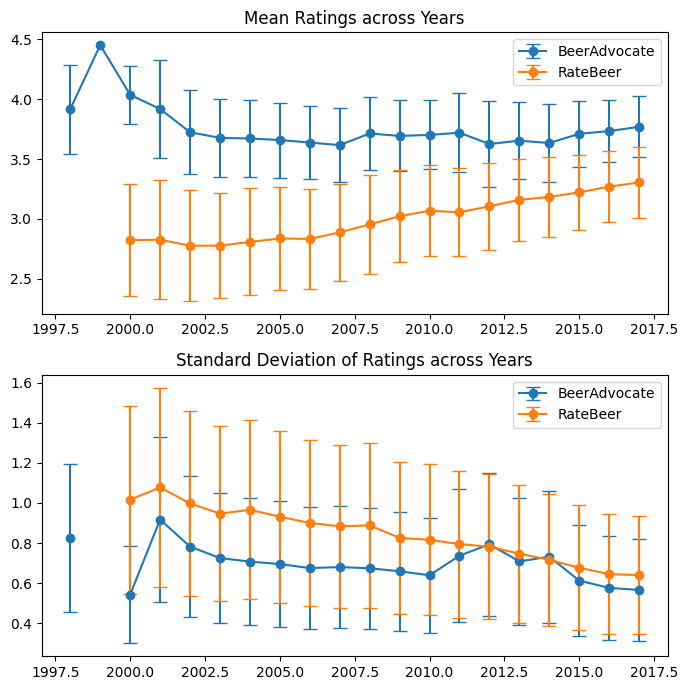

In [ ]:
print("Before standardization")
plot_mean_std_errorbar(mean_std_BA, mean_std_RB)

In [ ]:
mean_std_BA_standardized = ratings_BA_standardized.groupby('year')['std_rating'].agg(['mean', 'std'])
#mean_std_RB_standardized = ratings_RB_standardized.groupby('year')['std_rating'].agg(['mean', 'std'])
print("After standardization")
plot_mean_std_errorbar(mean_std_BA_standardized, mean_std_RB_standardized)

After standardization


NameError: name 'plot_mean_std_errorbar' is not defined

We still need to standardize the ratings from matched

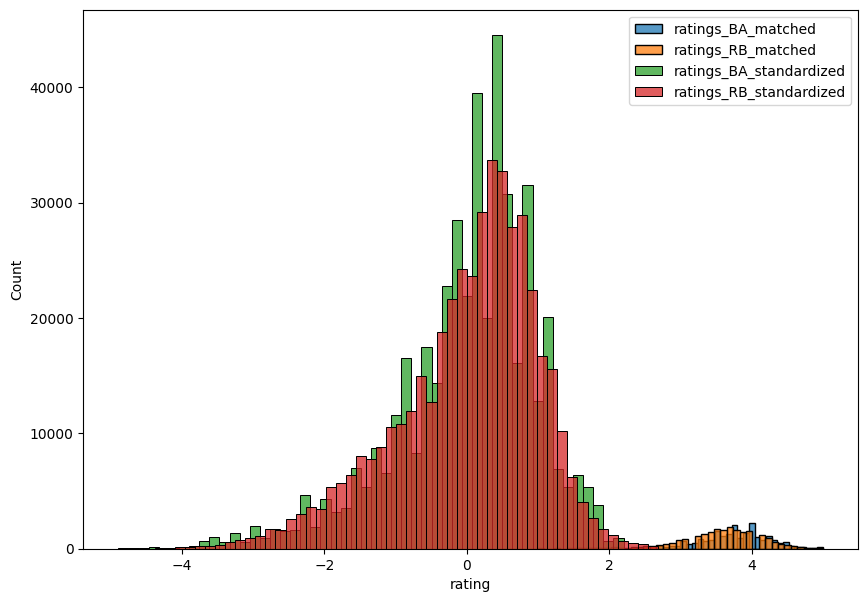

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(data=ratings_matched['rating'], bins=50, label = 'ratings_BA_matched')
sns.histplot(data=ratings_matched['rating.1'], bins=50, label = 'ratings_RB_matched')
sns.histplot(data=ratings_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_standardized')
sns.histplot(data=ratings_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_standardized')
plt.legend()
plt.show()

Standardize ratings from the matched

In [ ]:
ratings_matched_copy = ratings_matched.copy(deep=True)
ratings_matched_copy['beer_id.1'] = ratings_matched_copy['beer_id']
ratings_matched_copy['brewery_id.1'] = ratings_matched_copy['brewery_id']
ratings_matched_copy['beer_name.1'] = ratings_matched_copy['beer_name']
ratings_matched_copy['brewery_name.1'] = ratings_matched_copy['brewery_name']

# Retrieve the columns of interest for BeerAdvocate
ratings_matched_BA = ratings_matched_copy.iloc[:, :17]
ratings_matched_BA = ratings_matched_BA.drop(['review'], axis=1) # drop the column that is not common to both websites

# Retrieve the columns of interest for RateBeer
# ratings_matched_RB = ratings_matched_copy.iloc[:, 17:]
# ratings_matched_RB['overall.1'] = ratings_matched_RB['overall.1']*5/20
# ratings_matched_RB['aroma.1'] = ratings_matched_RB['aroma.1']*5/10
# ratings_matched_RB['taste.1'] = ratings_matched_RB['taste.1']*5/10
# ratings_matched_RB.columns = ratings_matched_BA.columns

# add time features to standardize by year
ratings_matched_BA_with_time = add_time_features(ratings_matched_BA)
#ratings_matched_RB_with_time = add_time_features(ratings_matched_RB)

# standardize ratings of matched data to have mean 0 and std 1
ratings_matched_BA_standardized, mean_std_BA_matched = standardize_annually_ratings(ratings_matched_BA_with_time) # adds column 'std_rating'
#ratings_matched_RB_standardized, mean_std_RB_matched = standardize_annually_ratings(ratings_matched_RB_with_time) # adds column 'std_rating'

### Check

- all dataframes have an additional column 'std_rating' with the standardized rating.

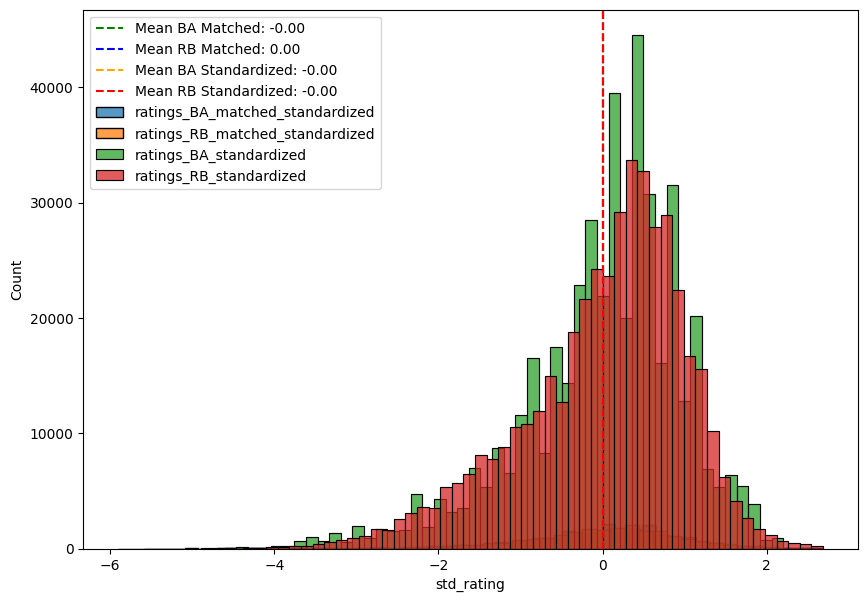

In [ ]:
# Compute mean values for each distribution
mean_rating_BA_matched = ratings_matched_BA_standardized['std_rating'].mean()
#mean_rating_RB_matched = ratings_matched_RB_standardized['std_rating'].mean()
mean_rating_BA_standardized = ratings_BA_standardized['std_rating'].mean()
#mean_rating_RB_standardized = ratings_RB_standardized['std_rating'].mean()


plt.figure(figsize=(10, 7))
sns.histplot(data=ratings_matched_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_matched_standardized')
sns.histplot(data=ratings_matched_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_matched_standardized')
sns.histplot(data=ratings_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_standardized')
sns.histplot(data=ratings_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_standardized')

# Plot vertical lines for mean values
plt.axvline(x=mean_rating_BA_matched, color='green', linestyle='--', label=f'Mean BA Matched: {mean_rating_BA_matched:.2f}')
plt.axvline(x=mean_rating_RB_matched, color='blue', linestyle='--', label=f'Mean RB Matched: {mean_rating_RB_matched:.2f}')
plt.axvline(x=mean_rating_BA_standardized, color='orange', linestyle='--', label=f'Mean BA Standardized: {mean_rating_BA_standardized:.2f}')
plt.axvline(x=mean_rating_RB_standardized, color='red', linestyle='--', label=f'Mean RB Standardized: {mean_rating_RB_standardized:.2f}')

plt.legend()
plt.show()

### Concatenate everything

Length of ratings matched: 21964
Length of ratings BA: 444338
Length of ratings RB: 446795
Length of combined dataset: 935058


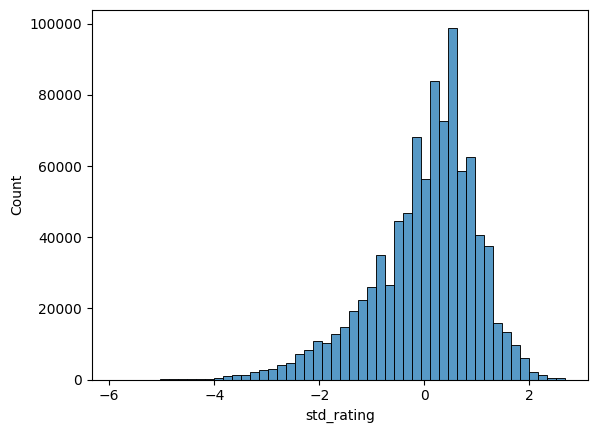

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,review,month,year,mean,std,std_rating
43736,"Hello, My Name Is Ingrid",67199.0,BrewDog,16315.0,American Double / Imperial IPA,8.2,2013-06-05,aztraz,aztraz.671249,NaN,...,NaN,NaN,3.5,nan,False,6.0,2013.0,3.653283,0.708228,-0.216431
25783,Fraoch Heather Ale,245.0,Williams Brothers Brewing Company,12142.0,Scottish Gruit / Ancient Herbed Ale,5.0,2013-08-07,ekalb31,ekalb31.747152,NaN,...,NaN,NaN,3.5,nan,False,8.0,2013.0,3.653283,0.708228,-0.216431


In [ ]:
# concatenate matched data from both websites
ratings_matched_BA_RB = pd.concat([ratings_matched_BA_standardized, ratings_matched_RB_standardized], axis=0)
ratings_matched_BA_RB.sort_values(by=['beer_id', 'user_id'], inplace=True)

# concatenate matched data with ratings_BA and ratings_RB
all_data= pd.concat([ratings_BA_standardized, 
                    ratings_RB_standardized,
                    ratings_matched_BA_RB], axis=0)

# test
print(f"Length of ratings matched: {len(ratings_matched)}")
print(f"Length of ratings BA: {len(ratings_BA)}")
print(f"Length of ratings RB: {len(ratings_RB)}")
print(f"Length of combined dataset: {len(all_data)}")

# check
sns.histplot(data=all_data['std_rating'], bins=50)
plt.show()

all_data.head(2)

**Copy paste this code until here to load and combine the dataset correctly**

NB: rating to use: **std_rating**

### **Loading and preprocessing done**

---


### Filtering of the beers and the breweries 

 - We'd like to filter the number of beers we keep in the data. We decided to eliminate beers with fewer than 10 reviews to maintain the ranking the credibility and ensures that the overall rating accurately reflects the consensus among a significant number of reviewers. Similarly we decided to keep breweries with more than 30 reviews. 

Text(0.5, 1.0, 'Distribution of the number of review per beer')

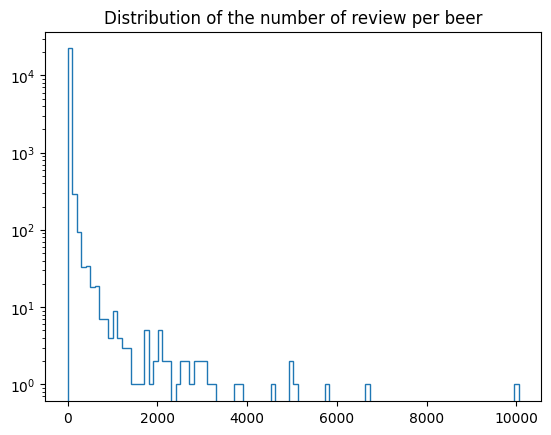

In [ ]:
nb_rev_beer = ratings_BA_standardized.groupby('beer_name').apply(lambda x:len(x))
plt.hist(nb_rev_beer,bins=100,log=True,histtype='step')
plt.title("Distribution of the number of review per beer")

In [258]:
ratings_Ba_filtered = ratings_BA_standardized.groupby('beer_name').filter(lambda x: len(x)>10)
values =sum(1 for element in nb_rev_beer.values if element <= 10)
length_beer =len(nb_rev_beer.values)
length_review =ratings_Ba_filtered.shape[0]
print(f"We kicked {values} beeer out of {length_beer} and {ratings_BA.shape[0]-length_review} out of {ratings_BA.shape[0]} reviews ")

We kicked 18356 beeer out of 22878 and 51067 out of 444338 reviews 


Text(0.5, 1.0, 'Distribution of the number of review per breweries')

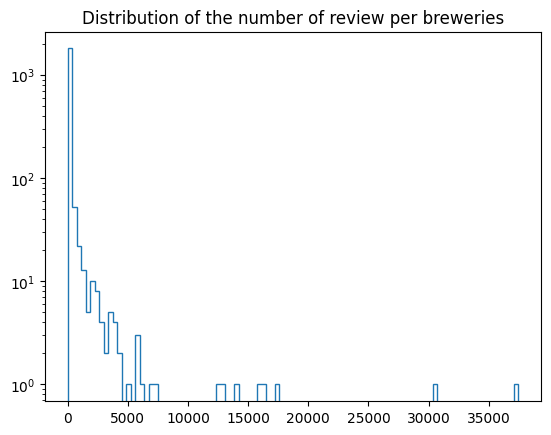

In [259]:
nb_rev_breweries = ratings_BA_standardized.groupby('brewery_name').apply(lambda x:len(x))
plt.hist(nb_rev_breweries,bins=100,log=True,histtype='step')
plt.title("Distribution of the number of review per breweries")

In [260]:
ratings_Ba_double_filtered = ratings_Ba_filtered.groupby('brewery_name').filter(lambda x: len(x)>30)
kicked_brew =sum(1 for element in nb_rev_breweries.values if element <= 10)
length_brew =len(nb_rev_breweries.values)
print(f"We kicked {kicked_brew} breweries out of {length_brew}")# and {ratings_BA.shape[0]-length_review} out of {ratings_BA.shape[0]} reviews ")

We kicked 934 breweries out of 1947


In [38]:
keeping_30["rating"] = keeping_30["rating"].astype(float)

In [ ]:
keeping_30

In [39]:
grouped = keeping_30.groupby(['brewery_name',"beer_name"])["rating"]
brew_count = keeping_30["brewery_name"].value_counts()
beer_count = keeping_30[["brewery_name","beer_name"]].value_counts()
result_df = grouped.agg(['mean', 'size'])
print(f"The size of the rating data is {keeping_30.shape}")
print(f"The number of ratings per breweries is {brew_count.head(4)}")
print(f"The number of ratings per breweries and beer is {beer_count.head(4)}")
print(f"Here are the aggregated mean per breweries + beer {result_df}")

The size of the rating data is (389602, 17)
The number of ratings per breweries is brewery_name
Unibroue                                37414
Samuel Smith Old Brewery (Tadcaster)    30614
Brasserie Dieu du Ciel!                 17049
Grupo Modelo S.A. de C.V.               15896
Name: count, dtype: int64
The number of ratings per breweries and beer is brewery_name                          beer_name                     
Unibroue                              La Fin Du Monde                   10046
Samuel Smith Old Brewery (Tadcaster)  Samuel Smith's Oatmeal Stout       6641
Wells & Young's Ltd                   Young's Double Chocolate Stout     5753
Brasserie Dieu du Ciel!               Péché Mortel                       5117
Name: count, dtype: int64
Here are the aggregated mean per breweries + beer                                                  mean  size
brewery_name           beer_name                           
33 Acres Brewing Co.   33 Acres Of Darkness  3.966667    27
         

brewery_name
33 Acres Brewing Co.     3.866558
4 Mile Brewing Co.       3.745000
5 Paddles Brewing Co.    3.729811
dtype: float64 brewery_name
33 Acres Brewing Co.     3.884344
4 Mile Brewing Co.       3.733345
5 Paddles Brewing Co.    3.752929
Name: mean, dtype: float64
brewery_name
Old Chimneys Brewery          4.350899
Superflux (Machine Ales)      4.259706
Cloudwater Brew Co.           4.186250
Traquair House Brewery Lld    4.144671
Driftwood Brewery             4.128630
Brasserie Auval               4.119479
Border Psycho Brewery         4.115000
Unibroue                      4.113760
Four Winds Brewing Co.        4.109003
Brasserie Dieu du Ciel!       4.105976
dtype: float64 brewery_name
Old Chimneys Brewery        4.327220
Superflux (Machine Ales)    4.276172
Redline Brewhouse           4.133208
Cloudwater Brew Co.         4.109622
Brasserie Auval             4.093442
Four Winds Brewing Co.      4.061525
Driftwood Brewery           4.057782
Sherbrooke Liquor Store     4.030761
B

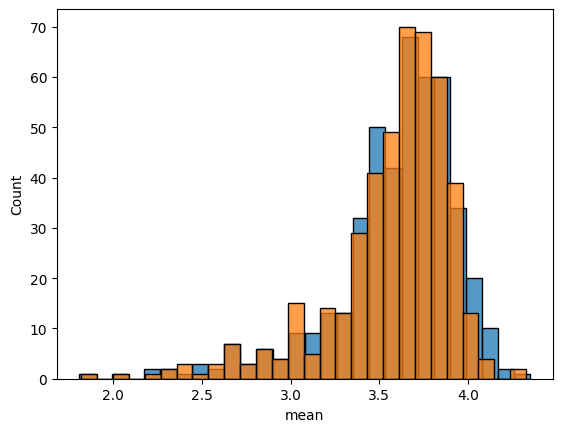

In [40]:
result_df['weighted_rating'] = result_df['mean'] * result_df['size']

#Herre we calculate the scores on one side we take into account the nb of ratings and not on the other one
df_average = result_df.groupby('brewery_name')['weighted_rating'].sum() / result_df.groupby('brewery_name')['size'].sum()
df_fair = result_df.groupby('brewery_name')['mean'].mean()

print(df_average.head(3), df_fair.head(3))

#Plot and take the n best
sns.histplot(df_average)
sns.histplot(df_fair)
best_brew_average = df_average.nlargest(10)
best_brew_fair = df_fair.nlargest(10)

print(best_brew_average ,best_brew_fair )

In [44]:
keeping_30.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text', 'review', 'month', 'year'],
      dtype='object')

In [43]:
keeping_30 = add_time_features(keeping_30)

In [46]:
grouped_year = keeping_30.groupby(['brewery_name',"beer_name","year"])["rating"]

stats_per_year = grouped_year.agg(['mean', 'size'])
# print(f"The size of the rating data is {keeping_30.shape}")
# print(f"The number of ratings per breweries is {brew_count.head(4)}")
# print(f"The number of ratings per breweries and beer is {beer_count.head(4)}")
print(f"Here are the aggregated mean per breweries + beer {stats_per_year}")

Here are the aggregated mean per breweries + beer                                                       mean  size
brewery_name           beer_name            year                
33 Acres Brewing Co.   33 Acres Of Darkness 2014  3.986000     5
                                            2015  4.072222     9
                                            2016  3.837500     8
                                            2017  3.964000     5
                       33 Acres Of Euphoria 2014  3.750000     1
...                                                    ...   ...
À l’abri de la Tempête Écume                2012  3.375000     4
                                            2013  3.625000     2
                                            2014  3.750000     1
                                            2015  3.806667     3
                                            2016  3.455000     2

[29366 rows x 2 columns]


In [112]:
stats_per_year['weighted_rating'] = stats_per_year['mean'] * stats_per_year['size']

#Herre we calculate the scores on one side we take into account the nb of ratings and not on the other one
df_average = stats_per_year.groupby(['brewery_name',"year"])['weighted_rating'].sum() / stats_per_year.groupby(['brewery_name',"year"])['size'].sum()
df_fair = stats_per_year.groupby(['brewery_name',"year"])['mean'].mean()

print(df_average.head(20))#, df_fair.head(3))

#Plot and take the n best
#sns.histplot(df_average)
#sns.histplot(df_fair)

best_brew_average = df_average.nlargest(10)
best_brew_fair = df_fair.nlargest(10)

#print(best_brew_average ,best_brew_fair )

brewery_name                  year
33 Acres Brewing Co.          2013    3.790000
                              2014    3.816667
                              2015    3.980909
                              2016    3.864474
                              2017    3.763333
4 Mile Brewing Co.            2014    3.745000
                              2015    3.950000
                              2016    3.680769
                              2017    3.747647
5 Paddles Brewing Co.         2013    2.990000
                              2014    3.729000
                              2015    3.681429
                              2016    3.847647
                              2017    3.670000
Adnams plc, Sole Bay Brewery  2002    3.737500
                              2003    4.092308
                              2004    3.857381
                              2005    3.972000
                              2006    3.916528
                              2007    3.811220
dtype: float64


In [250]:
sel = top_beers_year_avg.index.get_level_values(level=0)

hmmm = top_beers_year_avg[sel == 1998]
hmmm


brewery_name  rating
year year                                           
1998 1998                           Unibroue   4.775
     1998                      Whitbread PLC   4.480
     1998      Belhaven Brewery Company Ltd.   4.350
     1998                     Orkney Brewery   4.320
     1998                Elgood and Sons Ltd   4.230
     1998  Williams Brothers Brewing Company   3.970
     1998                 Shepherd Neame Ltd   3.800
     1998                  Alexander Keith's   2.850

In [251]:
averaged_per_year = df_average.reset_index(level='brewery_name')
fair_per_year = df_fair.reset_index("brewery_name")
averaged_per_year.columns.values[1] = 'rating'
fair_per_year.columns.values[1] = "rating"

# Optionally, you can rename the columns for clarity
#averaged_per_year.columns = ['year', 'average_rating']

# Display the resulting DataFrame
print(averaged_per_year.index,averaged_per_year.columns,type(averaged_per_year))

Index([2013, 2014, 2015, 2016, 2017, 2014, 2015, 2016, 2017, 2013,
       ...
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
      dtype='int32', name='year', length=4785) Index(['brewery_name', 'rating'], dtype='object') <class 'pandas.core.frame.DataFrame'>


In [226]:
#On garde les dix meilleurs par an

top_beers_year_avg = averaged_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'rating'))
top_beers_year_fair = fair_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'rating'))

#On compte le nombre de fois ou chaque brasserie est rentrée dans le top 10 et on prend les 3 meilleurs 
top_across_avg = top_beers_year_avg.groupby("brewery_name").value_counts().nlargest(3)
top_across_fair = top_beers_year_fair.groupby("brewery_name").value_counts().nlargest(3)

top_across_avg , top_across_fair

(brewery_name               rating
 Whitewater Brewing Co      4.30      2
 Alexander Keith's          2.85      1
 Alley Kat Brewing Company  4.43      1
 Name: count, dtype: int64,
 brewery_name                  rating  
 Whitewater Brewing Co         4.300000    2
 Adnams plc, Sole Bay Brewery  4.143704    1
 Alexander Keith's             2.850000    1
 Name: count, dtype: int64)

In [252]:
top_beers_year_avg

brewery_name    rating
year year                                                      
1998 1998                                    Unibroue  4.775000
     1998                               Whitbread PLC  4.480000
     1998               Belhaven Brewery Company Ltd.  4.350000
     1998                              Orkney Brewery  4.320000
     1998                         Elgood and Sons Ltd  4.230000
...                                               ...       ...
2017 2017                    Woodforde's Norfolk Ales  4.355000
     2017                   O'Hanlon Brewing Co. Ltd.  4.330769
     2017  Castle Eden & Camerons Brewing Company Ltd  4.330000
     2017                         Barley Days Brewery  4.326667
     2017                        Bristol Beer Factory  4.310000

[189 rows x 2 columns]

In [219]:
df_average["1998"]

KeyError: '1998'

In [217]:
top_beers_year_avg.sample(30)

,,brewery_name,rating
year,year,,
2005,2005,Brasserie Dieu du Ciel!,4.240000
2002,2002,Brutopia,4.600000
2008,2008,Whitewater Brewing Co,4.300000
2014,2014,Cotleigh Brewery,4.187500
2017,2017,O'Hanlon Brewing Co. Ltd.,4.330769
2013,2013,Driftwood Brewery,4.114313
2014,2014,Driftwood Brewery,4.177939
2012,2012,Crannóg Ales,4.166667
2015,2015,Atlas Brewery Ltd,4.290000


NameError: name 'top3_per_year' is not defined

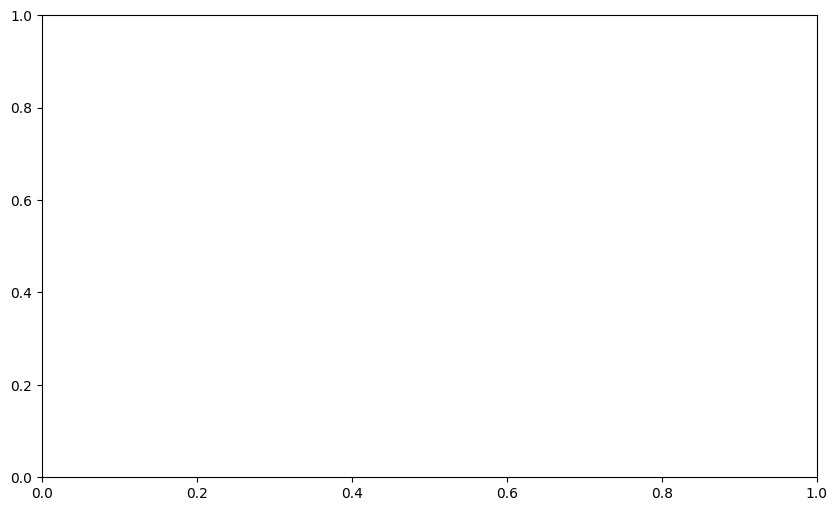

In [129]:
fig, ax = plt.subplots(figsize=(10, 6))


In [88]:
df

,brewery_name,year,rating
0,33 Acres Brewing Co.,2013,3.790000
1,33 Acres Brewing Co.,2014,3.816667
2,33 Acres Brewing Co.,2015,3.980909
3,33 Acres Brewing Co.,2016,3.864474
4,33 Acres Brewing Co.,2017,3.763333
...,...,...,...
4780,À l’abri de la Tempête,2013,3.844800
4781,À l’abri de la Tempête,2014,3.901000
4782,À l’abri de la Tempête,2015,3.801429
4783,À l’abri de la Tempête,2016,3.758889


In [92]:
df.columns

Index(['brewery_name', 'year', 'rating'], dtype='object')

In [101]:
top_10_beers = {}
for element in df["year"].unique():
    best_beers = df[df['year'] == element]
    print(type(best_beers),best_beers.columns)
    #.nlargest(10,columns = 'rating')['brewery_name'].tolist()
    top_10_beers[element] = best_beers
    
years = top_10_beers.keys()
#best_beers_per_year = pd.DataFrame([[year] + beer for year, best_beers[year] for year in top_10_beers])


<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> Index(['brewery_name', 'year', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'> In